# INSTALL REQUIREMENTS AND UPLOAD FILE

In [2]:
!pip install opendatasets

In [3]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re

In [4]:
od.download("kaggle.com/datasets/noorsaeed/holmes")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shaundevasiaroy
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/noorsaeed/holmes


100%|██████████| 88.2M/88.2M [00:05<00:00, 16.3MB/s]


In [8]:
input_file = '/content/holmes/holmes.txt'
with open(input_file, 'r', encoding='utf-8') as infile:
    data = infile.read()

In [10]:
data[:100]

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swi"

In [11]:
# Limit data to 500000 characters
data = data[:500000]

# DATA PRE PROCESSING

In [12]:
def remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(' +', ' ', text)

    return text

In [13]:
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized

# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)

In [14]:
# Tokenize words
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1


In [15]:
tokenizer.word_counts

OrderedDict([('project', 59),
             ('gutenbergs', 5),
             ('etext', 62),
             ('of', 2042),
             ('tom', 1065),
             ('swift', 310),
             ('and', 2430),
             ('his', 907),
             ('submarine', 237),
             ('boat', 73),
             ('4', 2),
             ('in', 1183),
             ('the', 6241),
             ('victor', 7),
             ('appletons', 2),
             ('series', 14),
             ('we', 484),
             ('name', 25),
             ('these', 39),
             ('files', 14),
             ('as', 731),
             ('they', 573),
             ('are', 208),
             ('numbered', 3),
             ('books', 9),
             ('ie', 2),
             ('this', 342),
             ('is', 348),
             ('so', 249),
             ('file', 12),
             ('04tomxxxxxx', 1),
             ('where', 135),
             ('xs', 2),
             ('place', 72),
             ('holders', 2),
             ('for', 796

In [16]:
tokenizer.word_index

{'<oov>': 1,
 'the': 2,
 'to': 3,
 'and': 4,
 'of': 5,
 'a': 6,
 'was': 7,
 'he': 8,
 'it': 9,
 'in': 10,
 'i': 11,
 'tom': 12,
 'you': 13,
 'that': 14,
 'his': 15,
 'mr': 16,
 'for': 17,
 'on': 18,
 'as': 19,
 'but': 20,
 'had': 21,
 'they': 22,
 'with': 23,
 'be': 24,
 'we': 25,
 'were': 26,
 'at': 27,
 'not': 28,
 'have': 29,
 'there': 30,
 'from': 31,
 'is': 32,
 'this': 33,
 'one': 34,
 'if': 35,
 'all': 36,
 'swift': 37,
 'by': 38,
 'him': 39,
 'out': 40,
 'well': 41,
 'no': 42,
 'up': 43,
 'some': 44,
 'what': 45,
 'an': 46,
 'my': 47,
 'or': 48,
 'do': 49,
 'get': 50,
 'so': 51,
 'will': 52,
 'them': 53,
 'could': 54,
 'submarine': 55,
 'car': 56,
 'then': 57,
 'would': 58,
 'damon': 59,
 'more': 60,
 'when': 61,
 'captain': 62,
 'did': 63,
 'sharp': 64,
 'about': 65,
 'now': 66,
 'are': 67,
 'me': 68,
 'which': 69,
 'dont': 70,
 'been': 71,
 'inventor': 72,
 'see': 73,
 'go': 74,
 'going': 75,
 'over': 76,
 'can': 77,
 'lad': 78,
 'cried': 79,
 'ill': 80,
 'asked': 81,
 'after

In [17]:
# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

In [19]:
# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print(input_sequences)

[[   0    0    0 ...    0  218 1569]
 [   0    0    0 ...  218 1569  211]
 [   0    0    0 ... 1569  211    5]
 ...
 [   0    0    0 ...   12   37    4]
 [   0    0    0 ...   37    4   15]
 [   0    0    0 ...    4   15 6119]]


In [20]:
# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [21]:
# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# LSTM MODEL

In [22]:
# Define your model
model = Sequential()
model.add(Embedding(total_words, 100))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_temp, y_train_temp, epochs=50, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.0966 - loss: 6.2728 - val_accuracy: 0.1409 - val_loss: 5.6451
Epoch 2/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.1558 - loss: 5.1443 - val_accuracy: 0.1539 - val_loss: 5.6411
Epoch 3/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.1778 - loss: 4.6703 - val_accuracy: 0.1548 - val_loss: 5.7661
Epoch 4/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.1996 - loss: 4.2903 - val_accuracy: 0.1360 - val_loss: 6.4396
Epoch 5/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.1986 - loss: 4.5343 - val_accuracy: 0.1505 - val_loss: 6.3754
Epoch 6/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.2241 - loss: 3.9809 - val_accuracy: 0.1474 - val_loss: 6.5785
Epoch 7/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.2373 - loss: 3.8062 - val_accuracy: 0.1469 - val_loss: 6.8422
Epoch 8/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.2471 - loss:

In [23]:
 # Save model architecture as JSON file
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("lstm_model_autocomplete.json", "w") as json_file:
     json_file.write(model_json)

In [ ]:
# Load model architecture from JSON file
# from tensorflow.keras.models import model_from_json

# with open("lstm_model_autocomplete.json", "r") as json_file:
#     loaded_model_json = json_file.read()

# # Create model from loaded architecture
# model = model_from_json(loaded_model_json)

# print("Model architecture loaded successfully from JSON file.")

# PLOTS TO SHOW LOSS AND ACCURACY

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

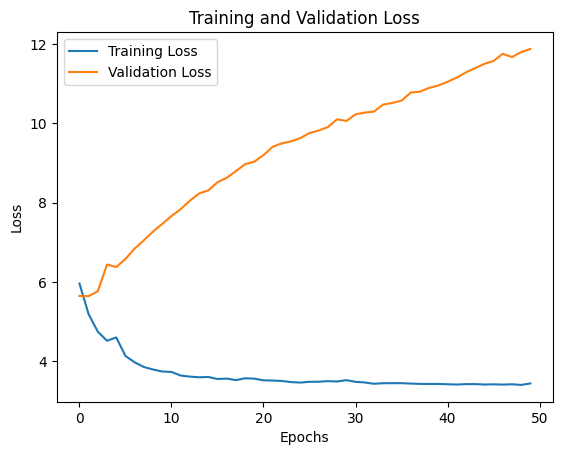

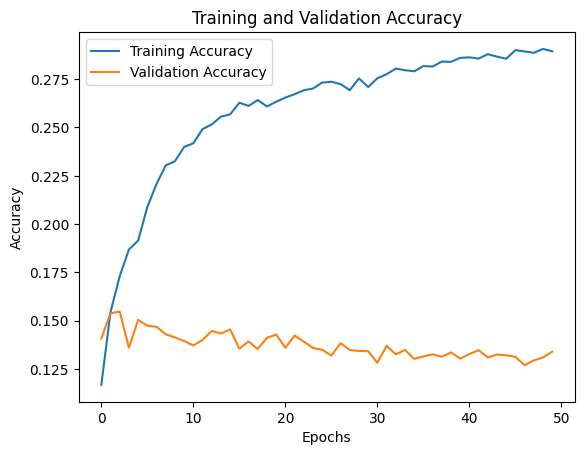

In [25]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# INFERENCE

In [26]:
def predict_top_five_words(model, tokenizer, input_text):
    token_list = tokenizer.texts_to_sequences([input_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

test 1

In [27]:
input_text = input("enter your input here")
predict_top_five_words(model,tokenizer,input_text)

enter your input herecopyright laws


['were', 'are', 'for', 'to', 'that']

test 2

In [28]:
input_text = input("enter your input here")
predict_top_five_words(model,tokenizer,input_text)

enter your input herewelcome 


['to', 'that', 'out', 'the', 'his']

test 3

In [29]:
input_text = input("enter your input here")
predict_top_five_words(model,tokenizer,input_text)

enter your input herehi how are


['you', 'within', 'always', 'the', 'going']

# FREEZING REQUIREMENTS AND PUSHING TO GITHUB


In [33]:
!pip freeze > requirements.txt
!ls -l
f = open("requirements.txt", "r")
print(f.read())

total 28
drwxr-xr-x 2 root root  4096 Feb 10 03:17 holmes
-rw-r--r-- 1 root root  5250 Feb 10 03:46 lstm_model_autocomplete.json
-rw-r--r-- 1 root root 11568 Feb 10 03:50 requirements.txt
drwxr-xr-x 1 root root  4096 Feb  6 14:19 sample_data
absl-py==1.4.0
accelerate==1.3.0
aiohappyeyeballs==2.4.4
aiohttp==3.11.11
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.3
ale-py==0.10.1
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.6.0
arviz==0.20.0
astropy==7.0.0
astropy-iers-data==0.2025.2.3.0.32.42
astunparse==1.6.3
atpublic==4.1.0
attrs==25.1.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
bigframes==1.34.0
bigquery-magics==0.5.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==3.0.0
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.1
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normal

ERROR: Could not find a version that satisfies the requirement git (from versions: none)
ERROR: No matching distribution found for git
